In [30]:
import scipy.io as sio
import numpy
import scipy
import numpy as np 
import time 
from scipy.signal import savgol_filter,find_peaks
from scipy.interpolate import splev, splrep, InterpolatedUnivariateSpline 
from pyfsi.fsiEnums import * 
from pyfsi.fsiExceptions import *
import csv
import math
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook   
from lmfit.models import LorentzianModel
from scipy.signal import savgol_filter
import logging
import pyfsi.fsiInitConfiguration as initCfg
import cupy as cp
import cupyx.scipy.linalg
from scipy.signal import chirp
from math import sqrt

In [31]:
'Linear Filter on GPU'

def ndim(self):
        return len(self._shape)  
    
def _validate_x(x):
    x = cp.asarray(x)
    if x.ndim == 0:
        raise ValueError('x must be at least 1-D')
    return x

def lfilter(b, a, x, axis=-1, zi=None):
    """
    Filter data along one-dimension with an IIR or FIR filter.
    Filter a data sequence, `x`, using a digital filter.  This works for many
    fundamental data types (including Object type).  The filter is a direct
    form II transposed implementation of the standard difference equation
    (see Notes).
    The function `sosfilt` (and filter design using ``output='sos'``) should be
    preferred over `lfilter` for most filtering tasks, as second-order sections
    have fewer numerical problems.
    Parameters
    ----------
    b : array_like
        The numerator coefficient vector in a 1-D sequence.
    a : array_like
        The denominator coefficient vector in a 1-D sequence.  If ``a[0]``
        is not 1, then both `a` and `b` are normalized by ``a[0]``.
    x : array_like
        An N-dimensional input array.
    axis : int, optional
        The axis of the input data array along which to apply the
        linear filter. The filter is applied to each subarray along
        this axis.  Default is -1.
    zi : array_like, optional
        Initial conditions for the filter delays.  It is a vector
        (or array of vectors for an N-dimensional input) of length
        ``max(len(a), len(b)) - 1``.  If `zi` is None or is not given then
        initial rest is assumed.  See `lfiltic` for more information.
    Returns
    -------
    y : array
        The output of the digital filter.
    zf : array, optional
        If `zi` is None, this is not returned, otherwise, `zf` holds the
        final filter delay values.
    
    
    """
    
    
    a = cp.atleast_1d(a)
   
    if len(a) != 1:
        # This path only supports types fdgFDGO to mirror _linear_filter below.
        # Any of b, a, x, or zi can set the dtype, but there is no default
        # casting of other types; instead a NotImplementedError is raised.
        b = cp.asarray(b)
       
        
        a = cp.asarray(a)
        if b.ndim != 1 and a.ndim != 1:
            raise ValueError('object of too small depth for desired array')
        x = _validate_x(x)
        inputs = [b, a, x]
        if zi is not None:
            # _linear_filter does not broadcast zi, but does do expansion of
            # singleton dims.
            zi = cp.asarray(zi)
            if zi.ndim != x.ndim:
                raise ValueError('object of too small depth for desired array')
            expected_shape = list(x.shape)
            expected_shape[axis] = b.shape[0] - 1
            expected_shape = tuple(expected_shape)
            # check the trivial case where zi is the right shape first
            if zi.shape != expected_shape:
                strides = zi.ndim * [None]
                if axis < 0:
                    axis += zi.ndim
                for k in range(zi.ndim):
                    if k == axis and zi.shape[k] == expected_shape[k]:
                        strides[k] = zi.strides[k]
                    elif k != axis and zi.shape[k] == expected_shape[k]:
                        strides[k] = zi.strides[k]
                    elif k != axis and zi.shape[k] == 1:
                        strides[k] = 0
                    else:
                        raise ValueError('Unexpected shape for zi: expected '
                                         '%s, found %s.' %
                                         (expected_shape, zi.shape))
                zi = cp.lib.stride_tricks.as_strided(zi, expected_shape,
                                                     strides)
            inputs.append(zi)
        dtype = cp.result_type(*inputs)
        
        if dtype.char not in 'fdgFDGO':
            raise NotImplementedError("input type '%s' not supported" % dtype)

        b = cp.array(b, dtype=dtype)
        a = cp.array(a, dtype=dtype, copy=False)
        b /= a[0]
        x = cp.array(x, dtype=dtype, copy=False)

        out_full = cp.apply_along_axis(lambda y: cp.convolve(b, y), axis, x)
        ind = out_full.ndim * [slice(None)]
        if zi is not None:
            ind[axis] = slice(zi.shape[axis])
            out_full[tuple(ind)] += zi

        ind[axis] = slice(out_full.shape[axis] - len(b) + 1)
        out = out_full[tuple(ind)]
        if zi is None:
            return out
        else:
            ind[axis] = slice(out_full.shape[axis] - len(b) + 1, None)
            zf = out_full[tuple(ind)]
            return out, zf
        

In [32]:
'GPU Butter Filter'

def buttap(N):
    """Return (z,p,k) for analog prototype of Nth-order Butterworth filter.
    The filter will have an angular (e.g., rad/s) cutoff frequency of 1.
    See Also
    --------
    butter : Filter design function using this prototype
    """
    pi =3.14
    if abs(int(N)) != N:
        raise ValueError("Filter order must be a nonnegative integer")
    z = cp.array([])
    m = cp.arange(-N+1, N, 2)
    # Middle value is 0 to ensure an exactly real pole
    p = -cp.exp(1j * pi * m / (2 * N))
    k = 1
    return z, p, k


pi=3.14

filter_dict = {'butter': [buttap],
               'butterworth': [buttap],
               }

band_dict = {'band': 'bandpass',
             'bandpass': 'bandpass',
             'pass': 'bandpass',
             'bp': 'bandpass',

             'bs': 'bandstop',
             'bandstop': 'bandstop',
             'bands': 'bandstop',
             'stop': 'bandstop',

             'l': 'lowpass',
             'low': 'lowpass',
             'lowpass': 'lowpass',
             'lp': 'lowpass',

             'high': 'highpass',
             'highpass': 'highpass',
             'h': 'highpass',
             'hp': 'highpass',
             }


def _relative_degree(z, p):
    """
    Return relative degree of transfer function from zeros and poles
    """
    degree = len(p) - len(z)
    if degree < 0:
        raise ValueError("Improper transfer function. "
                         "Must have at least as many poles as zeros.")
    else:
        return degree
    
    
    
def bilinear_zpk(z, p, k, fs):
    
    z = cp.atleast_1d(z)
    p = cp.atleast_1d(p)

    degree = _relative_degree(z, p)

    fs2 = 2.0*fs

    # Bilinear transform the poles and zeros
    z_z = (fs2 + z) / (fs2 - z)
    p_z = (fs2 + p) / (fs2 - p)

    # Any zeros that were at infinity get moved to the Nyquist frequency
    z_z = cp.append(z_z, -cp.ones(degree))

    # Compensate for gain change
    k_z = k * cp.real(cp.prod(fs2 - z) / cp.prod(fs2 - p))

    return z_z, p_z, k_z


def zpk2tf(z, p, k):
    
    z = cp.asnumpy(z)
    p = cp.asnumpy(p)
    k = cp.asnumpy(k)
    
    z = np.atleast_1d(z)
    k = np.atleast_1d(k)

    
    if len(z.shape) > 1:
        temp = np.poly(z[0])
        print(z[0])
        b = np.empty((z.shape[0], z.shape[1] + 1), temp.dtype.char)
        if len(k) == 1:
            k = [k[0]] * z.shape[0]
        for i in range(z.shape[0]):
            b[i] = k[i] * np.poly(z[i])
    else:
        b = k * np.poly(z)
    a = np.atleast_1d(np.poly(p))

    # Use real output if possible. Copied from numpy.poly, since
    # we can't depend on a specific version of numpy.
    if issubclass(b.dtype.type, numpy.complexfloating):
        # if complex roots are all complex conjugates, the roots are real.
        roots = numpy.asarray(z, complex)
        pos_roots = numpy.compress(roots.imag > 0, roots)
        neg_roots = numpy.conjugate(numpy.compress(roots.imag < 0, roots))
        if len(pos_roots) == len(neg_roots):
            if numpy.all(numpy.sort_complex(neg_roots) ==
                         numpy.sort_complex(pos_roots)):
                b = b.real.copy()

    if issubclass(a.dtype.type, numpy.complexfloating):
        # if complex roots are all complex conjugates, the roots are real.
        roots = numpy.asarray(p, complex)
        pos_roots = numpy.compress(roots.imag > 0, roots)
        neg_roots = numpy.conjugate(numpy.compress(roots.imag < 0, roots))
        if len(pos_roots) == len(neg_roots):
            if numpy.all(numpy.sort_complex(neg_roots) ==
                         numpy.sort_complex(pos_roots)):
                a = a.real.copy()

    return b, a

def lp2lp_zpk(z, p, k, wo=1.0):
    """
    Transform a lowpass filter prototype to a different frequency.
    Return an analog low-pass filter with cutoff frequency `wo`
    from an analog low-pass filter prototype with unity cutoff frequency,
    using zeros, poles, and gain ('zpk') representation.
    Parameters
    ----------
    z : array_like
        Zeros of the analog filter transfer function.
    p : array_like
        Poles of the analog filter transfer function.
    k : float
        System gain of the analog filter transfer function.
    wo : float
        Desired cutoff, as angular frequency (e.g., rad/s).
        Defaults to no change.
    Returns
    -------
    z : ndarray
        Zeros of the transformed low-pass filter transfer function.
    p : ndarray
        Poles of the transformed low-pass filter transfer function.
    k : float
        System gain of the transformed low-pass filter.
    
    """
    z = cp.atleast_1d(z)
    p = cp.atleast_1d(p)
    wo = float(wo)  # Avoid int wraparound

    degree = _relative_degree(z, p)

    # Scale all points radially from origin to shift cutoff frequency
    z_lp = wo * z
    p_lp = wo * p

    # Each shifted pole decreases gain by wo, each shifted zero increases it.
    # Cancel out the net change to keep overall gain the same
    k_lp = k * wo**degree

    return z_lp, p_lp, k_lp
  
    

def lp2hp_zpk(z, p, k, wo=1.0):
    """
    Transform a lowpass filter prototype to a highpass filter.
    Return an analog high-pass filter with cutoff frequency `wo`
    from an analog low-pass filter prototype with unity cutoff frequency,
    using zeros, poles, and gain ('zpk') representation.
    Parameters
    ----------
    z : array_like
        Zeros of the analog filter transfer function.
    p : array_like
        Poles of the analog filter transfer function.
    k : float
        System gain of the analog filter transfer function.
    wo : float
        Desired cutoff, as angular frequency (e.g., rad/s).
        Defaults to no change.
    Returns
    -------
    z : ndarray
        Zeros of the transformed high-pass filter transfer function.
    p : ndarray
        Poles of the transformed high-pass filter transfer function.
    k : float
        System gain of the transformed high-pass filter.
    
    """
    z = cp.atleast_1d(z)
    p = cp.atleast_1d(p)
    wo = float(wo)

    degree = _relative_degree(z, p)

    # Invert positions radially about unit circle to convert LPF to HPF
    # Scale all points radially from origin to shift cutoff frequency
    z_hp = wo / z
    p_hp = wo / p

    # If lowpass had zeros at infinity, inverting moves them to origin.
    z_hp = cp.append(z_hp, cp.zeros(degree))

    # Cancel out gain change caused by inversion
    k_hp = k * cp.real(cp.prod(-z) / cp.prod(-p))

    return z_hp, p_hp, k_hp
    

def iirfilter(N, Wn, rp=None, rs=None, btype='band', analog=False,
              ftype='butter', output='ba', fs=None):
    
    ftype, btype, output = [x.lower() for x in (ftype, btype, output)]
    Wn = cp.asarray(Wn)
    if fs is not None:
        if analog:
            raise ValueError("fs cannot be specified for an analog filter")
        Wn = 2*Wn/fs

    try:
        btype = band_dict[btype]
    except KeyError as e:
        raise ValueError("'%s' is an invalid bandtype for filter." % btype) from e

    try:
        typefunc = filter_dict[ftype][0]
    except KeyError as e:
        raise ValueError("'%s' is not a valid basic IIR filter." % ftype) from e

    if output not in ['ba', 'zpk']:
        raise ValueError("'%s' is not a valid output form." % output)

    if rp is not None and rp < 0:
        raise ValueError("passband ripple (rp) must be positive")

    if rs is not None and rs < 0:
        raise ValueError("stopband attenuation (rs) must be positive")

    # Get analog lowpass prototype
    if typefunc == buttap:
        z, p, k = typefunc(N)
    else:
        raise NotImplementedError("'%s' not implemented in iirfilter." % ftype)

    # Pre-warp frequencies for digital filter design
    if not analog:
        if cp.any(Wn <= 0) or cp.any(Wn >= 1):
            if fs is not None:
                raise ValueError("Digital filter critical frequencies "
                                 "must be 0 < Wn < fs/2 (fs={} -> fs/2={})".format(fs, fs/2))
            raise ValueError("Digital filter critical frequencies "
                             "must be 0 < Wn < 1")
        fs = 2.0
        warped = 2 * fs * cp.tan(pi * Wn / fs)
    else:
        warped = Wn

    # transform to lowpass, bandpass, highpass, or bandstop
    if btype in ('lowpass', 'highpass'):
        if btype == 'lowpass':
            z, p, k = lp2lp_zpk(z, p, k, wo=warped)
            
        elif btype == 'highpass':
            z, p, k = lp2hp_zpk(z, p, k, wo=warped)
    else:
        raise NotImplementedError("'%s' not implemented in iirfilter." % btype)

    # Find discrete equivalent if necessary
    if not analog:
       z, p, k = bilinear_zpk(z, p, k, fs=fs)
  
    # Transform to proper out type (pole-zero, state-space, numer-denom)
    if output == 'zpk':
        return z, p, k
    elif output == 'ba':
        return zpk2tf(z, p, k)
    
def butter(N, Wn, btype='low', analog=False, output='ba', fs=None):
    
    return iirfilter(N, Wn, btype=btype, analog=analog,
                     output=output, ftype='butter', fs=fs)


In [33]:
'Butterworth high pass filter'

def butter_highpass(cutoff, fs, order):
    """
    Create a Butterworth Highpass filter, according to specified parameters.

    Keyword arguments:
    ------------------
    cutoff  -- cutoff frequency
    fs      -- sampling frequency
    order   -- filter order

    Return:
    -------
    Filter coefficients b and a.
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a



def filterDataButterworthHighpass(data, cutoff, fs):
    """
    Apply a Butterworth highpass filter to the input data.

    Keyword arguments:
    ------------------
    data -- input data to be filtered
    cutoff -- cutoff frequency
    fs -- sampling frequency

    Return:
    -------
    Filtered data
    """
    b, a = butter_highpass(cutoff, fs, order=2)  # Order shouldnt't be too big!
    print("Butter ", (b), (a) )
    ret = lfilter(b, a, data)
    ret = cp.asnumpy(ret)
    return ret



In [34]:
'''Linearization on GPU

1.Change hilbert transform(done)
2.Add interpolation in CuPy

'''

'Hilbert Transform in GPU'

def ndim(self):
        return len(self._shape)
    
def hilbert(x, N=None, axis=-1):
    x = cp.asarray(x)
    if cp.iscomplexobj(x):
        raise ValueError("x must be real.")
    if N is None:
        N = x.shape[axis]
    if N <= 0:
        raise ValueError("N must be positive.")

    Xf = cupyx.scipy.fft.fft(x, N, axis=axis)
    h = cp.zeros(N)
    if N % 2 == 0:
        h[0] = h[N // 2] = 1
        h[1:N // 2] = 2
    else:
        h[0] = 1
        h[1:(N + 1) // 2] = 2

    if x.ndim > 1:
        ind = [np.newaxis] * x.ndim
        ind[axis] = slice(None)
        h = h[tuple(ind)]
    x = cupyx.scipy.fft.ifft(Xf * h, axis=axis)
    return x



'Spline Implementation for 1D in GPU with CuPy'


def cubic_interp1d_gpu(x0, x, y):
    """
    Interpolate a 1-D function using cubic splines.
      x0 : a float or an 1d-array
      x : (N,) array_like
          A 1-D array of real/complex values.
      y : (N,) array_like
          A 1-D array of real values. The length of y along the
          interpolation axis must be equal to the length of x.

    Implement a trick to generate at first step the cholesky matrice L of
    the tridiagonal matrice A (thus L is a bidiagonal matrice that
    can be solved in two distinct loops).

    additional ref: www.math.uh.edu/~jingqiu/math4364/spline.pdf 
    """

    x = cp.array(x, dtype='float')
    y = cp.array(y, dtype='float')
    

    # check if sorted
    if cp.any(cp.diff(x) < 0):
        indexes = cp.argsort(x)
        x = x[indexes]
        y = y[indexes]

    size = len(x)

    xdiff = cp.diff(x)
    ydiff = cp.diff(y)

    # allocate buffer matrices
    Li = cp.empty(size)
    Li_1 = cp.empty(size-1)
    z = cp.empty(size)

    # fill diagonals Li and Li-1 and solve [L][y] = [B]
    Li[0] = cp.sqrt(2*xdiff[0])
 
    Li_1[0] = 0.0
    B0 = 0.0 # natural boundary
    z[0] = cp.divide(B0,Li[0])

    for i in range(1, size-1, 1):
        Li_1[i] = cp.divide(xdiff[i-1],Li[i-1])
        Li[i] = cp.sqrt(cp.subtract(cp.multiply(2,cp.add(xdiff[i-1],xdiff[i])) ,cp.multiply(Li_1[i-1],Li_1[i-1])))
        Bi = cp.multiply(6,(cp.subtract(cp.divide(ydiff[i],xdiff[i]), cp.divide(ydiff[i-1],xdiff[i-1]))))
        z[i] = cp.divide(cp.subtract(Bi,cp.multiply(Li_1[i-1],z[i-1])),Li[i])

    i = size - 1
    Li_1[i-1] = cp.divide(xdiff[-1],Li[i-1])

    Li[i] = cp.sqrt(cp.subtract(cp.multiply(2,xdiff[-1]), cp.multiply(Li_1[i-1],Li_1[i-1])))
    Bi = 0.0 # natural boundary
    z[i] = cp.divide(cp.subtract(Bi, cp.multiply(Li_1[i-1],z[i-1])),Li[i])

    # solve [L.T][x] = [y]
    i = size-1
    z[i] = cp.divide(z[i] ,Li[i])
    for i in range(size-2, -1, -1):
        z[i] = cp.divide(cp.subtract(z[i],cp.multiply(Li_1[i-1],z[i+1])),Li[i])

    # find index
    
    index = cp.searchsorted(x,x0)
   
    cp.clip(index, 1, size-1, index)

    xi1, xi0 = x[index], x[index-1]
    yi1, yi0 = y[index], y[index-1]
    zi1, zi0 = z[index], z[index-1]
    hi1 = cp.subtract(xi1,xi0)

    f7 =cp.multiply(cp.divide(zi0,cp.multiply(6,hi1)), cp.power(cp.subtract(xi1,x0),3))
    f1 =cp.multiply(cp.divide(zi1,cp.multiply(6,hi1)), cp.power(cp.subtract(x0,xi0),3))
    f2 =cp.multiply(cp.subtract(cp.divide(yi1,hi1),cp.divide(cp.multiply(zi1,hi1),6)),cp.subtract(x0,xi0))
    f3 =cp.multiply(cp.subtract(cp.divide(yi0,hi1),cp.divide(cp.multiply(zi0,hi1),6)),cp.subtract(xi1,x0))
    f4 = cp.add(f7,f1)
    f5 = cp.add(f2,f3)
    f6 = cp.add(f4,f5)
        
    
    return f6


In [35]:


def DataLinearize_GPU(Tinterval, REF_IFM, GAS_CELL, MEAS) :
    """
    Data linearisation using the reference interferometer data

    Keyword arguments:
    ------------------
    Tinterval   -- sample spacing in seconds
    REF_IFM     -- reference interferometer raw data
    GAS_CELL    -- gas cell raw data
    MEAS        -- measurement interferometer raw data
    
    Return:
    -------
    GAS_CELL_out    -- linearized gas cell data
    MEAS_out        -- linearized measurement interferometer data
    """

    fs = 1/Tinterval
    REF_IFM = filterDataButterworthHighpass(REF_IFM, 100000, fs) 
    t = cp.linspace(0.0, len(REF_IFM)*Tinterval, num=len(REF_IFM))

    analytic_signal = hilbert(REF_IFM, axis=0)
    phase = cp.angle(analytic_signal) 
    instantaneous_phase = cp.unwrap(phase, axis=0)
    
    instantaneous_phase = cp.asnumpy(instantaneous_phase)

    
    f_theor = cp.max(instantaneous_phase)/(2*3.14*(Tinterval*len(instantaneous_phase)))
    t_simu = cp.array(instantaneous_phase/(2*3.14*f_theor))
    t_simu[0] = 0                                            # Otherwise the first value of t is below the interpolation range
    t_simu=cp.abs(t_simu)                                       
    t_simu.sort()

    '''
    MEAS_interpolated = splrep(t_simu, MEAS, k=1)            # Measurement interferometer signal interpolation
    MEAS_out = splev(t, MEAS_interpolated)

    
    GAS_CELL_interpolated = splrep(t_simu, GAS_CELL, k=1)    # Gas cell signal interpolation
    GAS_CELL_out = splev(t, GAS_CELL_interpolated)
    print("GAS_CELL_DATA from Scipy Interpolation",GAS_CELL_out)
    '''
    t_simu = cp.array(t_simu)
    MEAS = cp.array(MEAS)
    GAS_CELL= cp.array(GAS_CELL)
    MEAS_out = cp.interp(t, t_simu, MEAS)
    GAS_CELL_out = cp.interp(t, t_simu, GAS_CELL)
    
    
    
    return GAS_CELL_out, MEAS_out



'Linearization on CPU'

def DataLinearize_CPU(Tinterval, REF_IFM, GAS_CELL, MEAS) :
    """
    Data linearisation using the reference interferometer data

    Keyword arguments:
    ------------------
    Tinterval   -- sample spacing in seconds
    REF_IFM     -- reference interferometer raw data
    GAS_CELL    -- gas cell raw data
    MEAS        -- measurement interferometer raw data
    
    Return:
    -------
    GAS_CELL_out    -- linearized gas cell data
    MEAS_out        -- linearized measurement interferometer data
    """

    fs = 1/Tinterval
    REF_IFM = filterDataButterworthHighpass(REF_IFM, 100000, fs) 
    t = np.linspace(0.0, len(REF_IFM)*Tinterval, num=len(REF_IFM))

    analytic_signal = scipy.signal.hilbert(REF_IFM, axis=0)
    analytic_signal = np.array(analytic_signal)
    
    phase = np.angle(analytic_signal) 
    instantaneous_phase = np.unwrap(phase, axis=0)
    

    f_theor = max(instantaneous_phase)/(2*np.pi*(Tinterval*len(instantaneous_phase)))
    t_simu = instantaneous_phase/(2*np.pi*f_theor)
    t_simu[0] = 0                                            # Otherwise the first value of t is below the interpolation range
    t_simu=abs(t_simu)                                       
    t_simu.sort()
    
      
    MEAS_interpolated = splrep(t_simu, MEAS, k=1)            # Measurement interferometer signal interpolation
    MEAS_out = splev(t, MEAS_interpolated)

    GAS_CELL_interpolated = splrep(t_simu, GAS_CELL, k=1)    # Gas cell signal interpolation
    GAS_CELL_out = splev(t, GAS_CELL_interpolated)

    return GAS_CELL_out, MEAS_out



1.2500000000000001e-08
Sampling rate: 80.0 MSPS
Butter  [ 0.99944485 -1.99888971  0.99944485] [ 1.         -1.9988894   0.99889002]
--- Time for ButterWorth HP on GPU 0.029726743698120117 seconds 
Butter  [ 0.9944624  -1.98892481  0.9944624 ] [ 1.         -1.98889417  0.98895545]
--- Time to Linearize on CPU with SciPy interpolation 1.4707996845245361 seconds ---


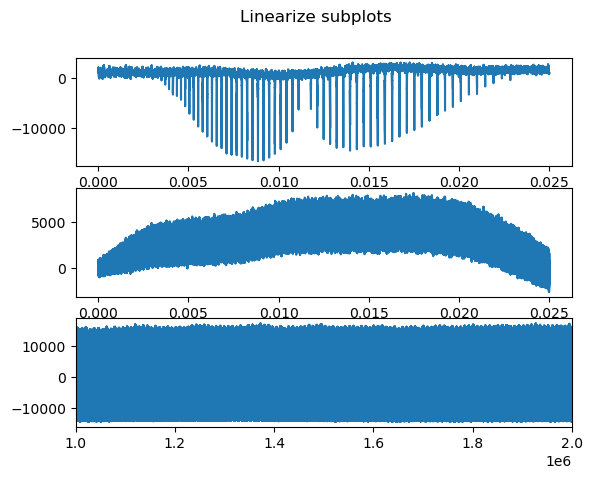

Butter  [ 0.9944624  -1.98892481  0.9944624 ] [ 1.         -1.98889417  0.98895545]
--- Time to Linearize on GPU with interpolation Cubic 1D 0.05962634086608887 seconds---


In [36]:
'Main Function for Linearization'

externalData = np.load('data/fsiDataForTomek.npy', allow_pickle=True)

rawData = { 
    'Measurement int'   : externalData[1], # Raw data from the measurement interferometer 
    'Gas cell'          : externalData[2],
    'Reference int'     : externalData[0],
    'Time interval'     : externalData[3]
}


Tinterval = rawData['Time interval']
print(rawData['Time interval'])
print('Sampling rate: ' + str((1/rawData['Time interval'])/1e6) + ' MSPS') 
REF_IM = rawData['Reference int']


start_time=time.time()
REF_IM = filterDataButterworthHighpass(rawData['Reference int'],100000,800000000)
print("--- Time for ButterWorth HP on GPU %s seconds " % (time.time() - start_time))
Time_GPU_BW = time.time() - start_time

start_time = time.time()

Gas_Linear, Meas_Linear =  DataLinearize_CPU(rawData['Time interval'], rawData['Reference int'], rawData['Gas cell'], rawData['Measurement int']) 
Time_CPU_Linear=time.time()-start_time
print("--- Time to Linearize on CPU with SciPy interpolation %s seconds ---" % (time.time() - start_time))

'Linearize plots'
#Gas_Linear, Meas_Linear =  DataLinearize_CPU(rawData['Time interval'], rawData['Reference int'], rawData['Gas cell'], rawData['Measurement int']) 
REF_IM = rawData['Reference int']
x = np.arange(0,2000000, 1)
y = Gas_Linear
y2 = Meas_Linear
y3 = rawData['Reference int']
x3 = np.linspace(0.0, len(REF_IM)*Tinterval, num=len(REF_IM))

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Linearize subplots')
ax1.plot(x3, y)
ax2.plot(x3, y2)
ax3.plot(x, y3)

plt.xlim(1000000,2000000)

plt.show()

start_time = time.time()

Gas_Linear, Meas_Linear =  DataLinearize_GPU(rawData['Time interval'], rawData['Reference int'], rawData['Gas cell'], rawData['Measurement int']) 
Time_GPU_Linear=time.time()-start_time
print("--- Time to Linearize on GPU with interpolation Cubic 1D %s seconds---" % (time.time() - start_time))


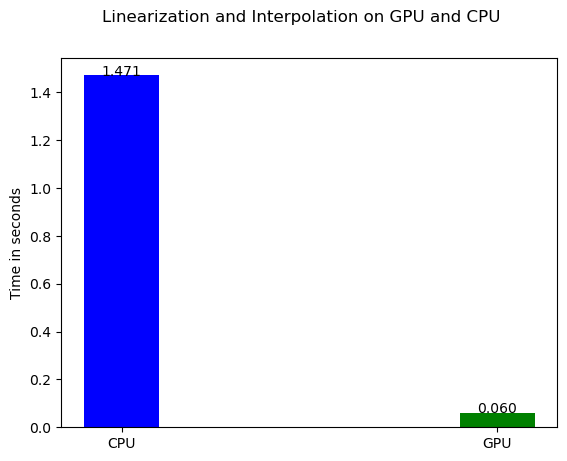

--- Time to Linearize on GPU is 24.704318817131096 times faster tha CPU ---


In [42]:
colors=['blue', 'green']
names = ['CPU', 'GPU']
x_hist=[Time_CPU_Linear,Time_GPU_Linear]
x= [0,1]

plt.bar(x, x_hist, width=0.2, align='center', color=colors)
plt.xticks(x,names)
plt.ylabel('Time in seconds')
plt.suptitle('Linearization and Interpolation on GPU and CPU')
for i in range(len(x_hist)):
        plt.text(i,x_hist[i],str("%.3f" % x_hist[i]), ha='center')
plt.show()

print("--- Time to Linearize on GPU is %s times faster tha CPU ---" % (Time_CPU_Linear/Time_GPU_Linear))